In [1]:
import os
import json
import csv
import numpy as np
import pandas as pd

from html import unescape
import re
import string
import wordsegment as ws
ws.load()
import emoji

from collections import Counter
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf

In [2]:
# Import matplotlib
pd.plotting.register_matplotlib_converters()
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
model_all_checkpoint_file = "wilds-singletask-conditional-all.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
print(tf.executing_eagerly())
print(gpus) # check if gpu is recognized

# Currently, memory growth needs to be the same across GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
"""
import tensorflow libraries afer allowing gpu growth, else tensorflow crashes 
"""

from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig

D:\Anaconda\envs\tf2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
"""
Preprocessing Script
"""

# Define helper function for segmenting hashtags found through regex
def regex_match_segmentation(match):
    return ' '.join(ws.segment(match.group(0)))

# Define function for cleaning text
def clean_text(text):
    
    # convert HTML codes
    text = unescape(text)
    
    # lowercase text
    text = text.lower()
    
    # replace mentions, URLs and emojis with special token
    text = re.sub(r"@[A-Za-z0-9_-]+",'[USER]',text)
    text = re.sub(r"http\S+",'[URL]',text)
#     text = ''.join(' [EMOJI] ' if (char in emoji.UNICODE_EMOJI) else char for char in text).strip()
    
    # find and split hashtags into words
    text = re.sub(r"#[A-Za-z0-9]+", regex_match_segmentation, text)

    # remove punctuation at beginning of string (quirk in Davidson data)
    text = text.lstrip("!")
    
    # remove newline and tab characters
    text = text.replace('\n',' ')
    text = text.replace('\t',' ')
    
    words = text.split()
    # hard coded 128, max word length
    if len(words) > 128:
        words = words[:128]
    
    text = ' '.join(words)
    
    return text

In [6]:
"""
Codalab link to dataset: https://worksheets.codalab.org/bundles/0x8cd3de0634154aeaad2ee6eb96723c6e
Acquired from Pang Wei Koh's Homepage: https://koh.pw/

Koh, Pang Wei, et al. "Wilds: A benchmark of in-the-wild distribution shifts." 
International Conference on Machine Learning. PMLR, 2021.
"""

metadata_df = pd.read_csv('all_data_with_identities.csv', index_col=0)

train_data = metadata_df.loc[metadata_df['split'] == 'train']
test_data = metadata_df.loc[metadata_df['split'] == 'test']

# pick instances where the target gender is either men or women or both
def pick_men_women(df):
    gen_data = df.loc[df['na_gender'] == 0]
    
    both_df = gen_data.loc[(gen_data['male'] > 0.5) & (gen_data['female'] > 0.5)]
    men_df = gen_data.loc[(gen_data['male'] > 0.5) & (gen_data['female'] < 0.5)]
    women_df = gen_data.loc[(gen_data['female'] > 0.5) & (gen_data['male'] < 0.5)]
        
    return both_df, men_df, women_df
    
    
both_train_df, men_train_df, women_train_df = pick_men_women(train_data)
both_test_df, men_test_df, women_test_df = pick_men_women(test_data)

In [7]:
"""
tweets where both genders are targeted
"""

both_train = list(both_train_df['comment_text'])
both_train = [clean_text(x) for x in both_train]
both_train_bool = (both_train_df['toxicity'].values >= 0.5)

both_train_lab = []
# for all of the both targeted tweets
for i in range(len(both_train)):
    # if the tweet is toxic
    if both_train_bool[i] == 1:
        both_train_lab.append((1, (1,0), (1,1)))
    else:
        both_train_lab.append((0, (0,0), (0,1)))

both_train_lab = np.asarray(both_train_lab,dtype=object)


both_test = list(both_test_df['comment_text'])
both_test = [clean_text(x) for x in both_test]
both_test_bool = (both_test_df['toxicity'].values >= 0.5)

both_test_lab = []
for i in range(len(both_test)):
    if both_test_bool[i] == 1:
        both_test_lab.append((1, (1,0), (1,1)))
    else:
        both_test_lab.append((0, (0,0), (0,1)))

both_test_lab = np.asarray(both_test_lab,dtype=object)


"""
tweets where only men are targeted
"""

men_train = list(men_train_df['comment_text'])
men_train = [clean_text(x) for x in men_train]
men_train_bool = (men_train_df['toxicity'].values >= 0.5)

men_train_lab = []
# for all of the men targeted tweets
for i in range(len(men_train)):
    # if the tweet is toxic
    if men_train_bool[i] == 1:
        men_train_lab.append((1, (1,0), (0,0)))
    else:
        men_train_lab.append((0, (0,0), (0,0)))

men_train_lab = np.asarray(men_train_lab,dtype=object)


men_test = list(men_test_df['comment_text'])
men_test = [clean_text(x) for x in men_test]
men_test_bool = (men_test_df['toxicity'].values >= 0.5)

men_test_lab = []
for i in range(len(men_test)):
    if men_test_bool[i] == 1:
        men_test_lab.append((1, (1,0), (0,0)))
    else:
        men_test_lab.append((0, (0,0), (0,0)))

men_test_lab = np.asarray(men_test_lab,dtype=object)


"""
tweets where only women are targeted
"""

women_train = list(women_train_df['comment_text'])
women_train = [clean_text(x) for x in women_train]
women_train_bool = (women_train_df['toxicity'].values >= 0.5)

women_train_lab = []
for i in range(len(women_train)):
    # if the tweet is toxic
    if women_train_bool[i] == 1:
        women_train_lab.append((1, (0,1), (1,1)))
    else:
        women_train_lab.append((0, (0,1), (0,1)))

women_train_lab = np.asarray(women_train_lab,dtype=object)


women_test = list(women_test_df['comment_text'])
women_test = [clean_text(x) for x in women_test]
women_test_bool = (women_test_df['toxicity'].values >= 0.5)

women_test_lab = []
for i in range(len(women_test)):
    # if the tweet is toxic
    if women_test_bool[i] == 1:
        women_test_lab.append((1, (0,1), (1,1)))
    else:
        women_test_lab.append((0, (0,1), (0,1)))

women_test_lab = np.asarray(women_test_lab,dtype=object)


# generate final train and test batches
train_tweets = both_train + men_train + women_train
train_labels = np.concatenate((both_train_lab,men_train_lab,women_train_lab), axis=0)
test_tweets = both_test + men_test + women_test
test_labels = np.concatenate((both_test_lab,men_test_lab,women_test_lab), axis=0)

In [8]:
"""
Base Version of the code including Batch Encoding, Tokenization, and Model Configuration are adopted from the following link:
https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
"""

def batch_encode(tokenizer, texts, batch_size=256, max_length=128): 
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)


In [9]:
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_ids, X_train_attention = batch_encode(tokenizer, train_tweets)

In [10]:
# acquire tweet labels to compute weights for class imbalance between toxic/non-toxic
yy_all = np.asarray([float(label[0]) for label in train_labels])

weights = compute_class_weight('balanced', classes=np.unique(yy_all), y=yy_all)

def cust_loss_all(y_true, y_pred): 
    intermed = tf.keras.backend.expand_dims(y_true[:,0], 1)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    err = bce(intermed, y_pred)
    
    weight_vector = intermed * weights[1] + (1 - intermed) * weights[0]
    weighted_bce = weight_vector * err

    werr = tf.keras.backend.mean(weighted_bce)

    return werr

In [11]:
def build_model(transformer, max_length=128):
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal() 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    D1 = tf.keras.layers.Dropout(0.1)(cls_token)
    
    X = tf.keras.layers.Dense(512,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(0.1)(X)
    
    X = tf.keras.layers.Dense(128,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)
    
    D3 = tf.keras.layers.Dropout(0.1)(X)
    
    X = tf.keras.layers.Dense(64,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D3)
    
    D4 = tf.keras.layers.Dropout(0.1)(X)
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D4)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    return model
    

In [12]:
# The bare, pretrained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Freeze DistilBERT layers to preserve pre-trained weights 
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [13]:
# Build model
model_all = build_model(distilBERT)

D:\Anaconda\envs\tf2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
# model_all.summary()

In [15]:
# Compile the model
model_all.compile(tf.keras.optimizers.Adamax(lr=1e-4), loss=cust_loss_all)

D:\Anaconda\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
model_all_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_all_checkpoint_file, monitor='loss', verbose=1, save_best_only=True, mode='min')
# model_all.load_weights(model_all_checkpoint_file)

In [17]:
# Train the model
train_history_all = model_all.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(yy_all),
    epochs = 1,
    batch_size = 64, 
    steps_per_epoch = len(train_tweets) // 64,
    verbose=True,
    callbacks=[model_all_checkpoint]
)

759/759 [==============================] - ETA: 0s - loss: 0.3591
Epoch 1: loss improved from inf to 0.35912, saving model to wilds-singletask-conditional-all.h5
759/759 [==============================] - 191s 236ms/step - loss: 0.3591


In [18]:
# identify which tweets in test set targets which gender group
men_indices = [i for i in range(len(test_labels)) if test_labels[i][1][1] == 0]
women_indices = [i for i in range(len(test_labels)) if test_labels[i][2][1] == 1]
                  
men_te_lab = [tuple(map(float, test_labels[index][1])) for index in men_indices]
women_te_lab = [tuple(map(float, test_labels[index][2])) for index in women_indices]

In [19]:
# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, test_tweets)

706/706 [==============================] - 93s 128ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     19236
         1.0       0.55      0.24      0.34      3350

    accuracy                           0.86     22586
   macro avg       0.72      0.60      0.63     22586
weighted avg       0.83      0.86      0.83     22586



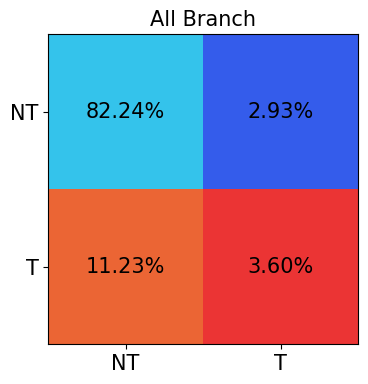

In [20]:
y_test = np.asarray([float(label[0]) for label in test_labels])

# Generate predictions
y_pred = model_all.predict([X_test_ids, X_test_attention])
y_pred = np.squeeze(np.array(y_pred)).T
y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)

'''
First performs a classification report on model_all on all test data.
Second performs a classification report on model_all on men data.
Third performs a classification report on model_all on black women data.
'''
print(classification_report(y_test, y_pred_thresh, zero_division=0))
# print(classification_report(y_test[men_indices], y_pred_thresh[men_indices], zero_division=0))
# print(classification_report(y_test[women_indices], y_pred_thresh[women_indices], zero_division=0))

palette = np.array([[52, 195, 235],   # black
                    [52, 92, 235],   # red
                    [235, 101, 52],   # green
                    [235, 52, 52],   # blue
                    ])  # white

I = np.array([[0 , 1], [2, 3]])
RGB = palette[I]

fig0 = plt.figure(figsize=(4,5))
ax1 = fig0.add_subplot(111)
cm1 = confusion_matrix(y_test, y_pred_thresh)
ax1.imshow(RGB)

size=15

for i in range(2):
    for j in range(2):
        c = 100 * cm1[j,i] / len(y_test)
        ax1.text(i, j, f'{c:.2f}%', va='center', ha='center', color='black', fontsize=size)

ax1.set_title('All Branch', fontsize=size)
ax1.set_xticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)
ax1.set_yticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)

## MEN MODEL

In [21]:
model_men_checkpoint_file = "wilds-singletask-conditional-men.h5"
model_men = build_model(distilBERT)

D:\Anaconda\envs\tf2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [22]:
men_indices_tr = [i for i in range(len(train_labels)) if train_labels[i][1][1] == 0]
men_tr_lab = [tuple(map(float, train_labels[index][1])) for index in men_indices_tr]

men_tweets = [train_tweets[index] for index in men_indices_tr]
X_train_ids, X_train_attention = batch_encode(tokenizer, men_tweets)

In [23]:
labels_men = [label[0] for label in men_tr_lab]
men_weights = compute_class_weight('balanced', classes=np.unique(labels_men), y=labels_men)

def cust_loss_men(y_true, y_pred): 
    intermed = tf.keras.backend.expand_dims(y_true[:,0], 1)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    err = bce(intermed, y_pred)
    
    weight_vector = intermed * men_weights[1] + (1 - intermed) * men_weights[0]
    weighted_bce = weight_vector * err

    werr = tf.keras.backend.mean(weighted_bce)

    return werr

In [24]:
model_men.compile(tf.keras.optimizers.Adamax(lr=1e-4), loss=cust_loss_men)

D:\Anaconda\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
model_men_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_men_checkpoint_file, monitor='loss', verbose=1, save_best_only=True, mode='min')
# model_men.load_weights(model_men_checkpoint_file)

In [26]:
# Train the model
train_history_men = model_men.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(labels_men),
    epochs = 1,
    batch_size = 64, 
    steps_per_epoch = len(men_tr_lab) // 64,
    verbose=True,
    callbacks=[model_men_checkpoint]
)

413/413 [==============================] - ETA: 0s - loss: 0.3702
Epoch 1: loss improved from inf to 0.37019, saving model to wilds-singletask-conditional-men.h5
413/413 [==============================] - 114s 238ms/step - loss: 0.3702


706/706 [==============================] - 93s 127ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     10694
         1.0       0.57      0.21      0.31      1920

    accuracy                           0.86     12614
   macro avg       0.72      0.59      0.61     12614
weighted avg       0.83      0.86      0.83     12614



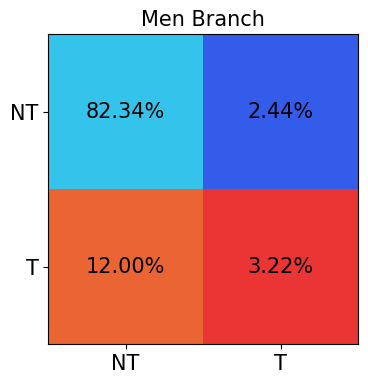

In [27]:
# Encode X_test
y_test_men = np.asarray(men_te_lab)

# Generate predictions
y_pred = model_men.predict([X_test_ids, X_test_attention])
y_pred = np.squeeze(np.array(y_pred)).T
y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)

'''
Performs a classification report on men model on men data.
'''
print(classification_report(y_test_men[:,0], y_pred_thresh[men_indices], zero_division=0))

palette = np.array([[52, 195, 235],   # black
                    [52, 92, 235],   # red
                    [235, 101, 52],   # green
                    [235, 52, 52],   # blue
                    ])  # white

I = np.array([[0 , 1], [2, 3]])
RGB = palette[I]

fig0 = plt.figure(figsize=(4,5))
ax1 = fig0.add_subplot(111)
cm1 = confusion_matrix(y_test_men[:,0], y_pred_thresh[men_indices])
ax1.imshow(RGB)

size=15

for i in range(2):
    for j in range(2):
        c = 100 * cm1[j,i] / len(y_test_men)
        ax1.text(i, j, f'{c:.2f}%', va='center', ha='center', color='black', fontsize=size)

ax1.set_title('Men Branch', fontsize=size)
ax1.set_xticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)
ax1.set_yticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)

## WOMEN MODEL

In [28]:
model_women_checkpoint_file = "wilds-singletask-conditional-women.h5"
model_women = build_model(distilBERT)

D:\Anaconda\envs\tf2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [29]:
women_indices_tr = [i for i in range(len(train_labels)) if train_labels[i][2][1] == 1]
women_tr_lab = [tuple(map(float, train_labels[index][2])) for index in women_indices_tr]

women_tweets = [train_tweets[index] for index in women_indices_tr]
X_train_ids, X_train_attention = batch_encode(tokenizer, women_tweets)

In [30]:
labels_women = [label[0] for label in women_tr_lab]
women_weights = compute_class_weight('balanced', classes=np.unique(labels_women), y=labels_women)

def cust_loss_women(y_true, y_pred): 
    intermed = tf.keras.backend.expand_dims(y_true[:,0], 1)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    err = bce(intermed, y_pred)
    
    weight_vector = intermed * women_weights[1] + (1 - intermed) * women_weights[0]
    weighted_bce = weight_vector * err

    werr = tf.keras.backend.mean(weighted_bce)

    return werr

In [31]:
model_women.compile(tf.keras.optimizers.Adamax(lr=1e-4), loss=cust_loss_women)

D:\Anaconda\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model_women_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_women_checkpoint_file, monitor='loss', verbose=1, save_best_only=True, mode='min')
# model_women.load_weights(model_women_checkpoint_file)

In [33]:
# Train the model
train_history_women = model_women.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array([label[0] for label in women_tr_lab]),
    epochs = 1,
    batch_size = 64, 
    steps_per_epoch = len(women_tr_lab) // 64,
    verbose=True,
    callbacks=[model_women_checkpoint]
)

520/520 [==============================] - ETA: 0s - loss: 0.3438
Epoch 1: loss improved from inf to 0.34375, saving model to wilds-singletask-conditional-women.h5
520/520 [==============================] - 133s 233ms/step - loss: 0.3438


706/706 [==============================] - 91s 124ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     12964
         1.0       0.58      0.18      0.28      2068

    accuracy                           0.87     15032
   macro avg       0.73      0.58      0.60     15032
weighted avg       0.84      0.87      0.84     15032



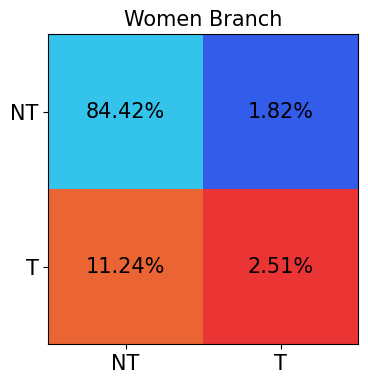

In [34]:
# Encode X_test
y_test_women = np.asarray(women_te_lab)

# Generate predictions
y_pred = model_women.predict([X_test_ids, X_test_attention])
y_pred = np.squeeze(np.array(y_pred)).T
y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)

'''
Performs a classification report on women model on women data.
'''
print(classification_report(y_test_women[:,0], y_pred_thresh[women_indices], zero_division=0))

palette = np.array([[52, 195, 235],   # black
                    [52, 92, 235],   # red
                    [235, 101, 52],   # green
                    [235, 52, 52],   # blue
                    ])  # white

I = np.array([[0 , 1], [2, 3]])
RGB = palette[I]

fig0 = plt.figure(figsize=(4,5))
ax1 = fig0.add_subplot(111)
cm1 = confusion_matrix(y_test_women[:,0], y_pred_thresh[women_indices])
ax1.imshow(RGB)

size=15

for i in range(2):
    for j in range(2):
        c = 100 * cm1[j,i] / len(y_test_women)
        ax1.text(i, j, f'{c:.2f}%', va='center', ha='center', color='black', fontsize=size)

ax1.set_title('Women Branch', fontsize=size)
ax1.set_xticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)
ax1.set_yticks(np.arange(0, 2), ['NT', 'T'], fontsize=size)